In [114]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from pykml.factory import KML_ElementMaker as KML
import lxml

In [115]:
#Read result_df with pickle
read_folder = './model_bouy_comparison/'
result_df_fn = 'result_df'

with open(os.path.join(read_folder, result_df_fn),'rb') as f_r:
    result_df = pickle.load(f_r)

In [116]:
result_df 


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 00:00:00,WSPD,7.299,3.107290,80.5,-12.0,2021-01-01 00:00:00
1,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 01:00:00,WSPD,3.099,3.274450,80.5,-12.0,2021-01-01 01:00:00
2,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 02:00:00,WSPD,3.699,4.073387,80.5,-12.0,2021-01-01 02:00:00
3,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 03:00:00,WSPD,3.899,4.935715,80.5,-12.0,2021-01-01 03:00:00
4,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 04:00:00,WSPD,5.499,4.728475,80.5,-12.0,2021-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
866,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-29 15:00:00,VAVH,1.649,1.581359,115.5,-32.0,2021-12-29 15:00:00
867,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-30 18:00:00,VAVH,2.139,1.752544,115.5,-32.0,2021-12-30 18:00:00
868,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-31 06:00:00,VAVH,1.899,1.729530,115.5,-32.0,2021-12-31 06:00:00
869,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-31 09:00:00,VAVH,2.009,2.069573,115.5,-32.0,2021-12-31 09:00:00


In [117]:
#entries with 0 as buoy_value
result_df_zero = result_df[result_df['bouy_variable_value'] == 0]
print(result_df_zero.value_counts(subset=['bouy_file_name', 'bouy_variable_name']))
display(result_df_zero)

Series([], dtype: int64)


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time


In [118]:
def scatterplot_and_heatmaps(name_text, df, units, alpha=0.01):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    axs[0].scatter(df['bouy_variable_value'], df['model_value'], alpha=alpha)
    axs[0].set_title('Scatterplot ' + name_text)
    axs[0].set_xlabel("bouy measurement")
    axs[0].set_ylabel("model measurement")


    (h2d_h, h2d_xedg, h2d_yedg, h2d_img) = axs[1].hist2d(df['bouy_variable_value'], df['model_value'], bins=100, norm=mpl.colors.LogNorm(clip=True))
    axs[1].set_title('Heatmap ' + name_text + ', log scaled colormap')
    axs[1].set_xlabel("bouy measurement")
    axs[1].set_ylabel("model measurement")
    fig.colorbar(h2d_img, ax=axs[1], label='Count colormap')

    hist = h2d_h.copy().T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist *= 1 / hist.sum(axis=0, keepdims=True)
        
    #Remove nan
    hist[np.isnan(hist)] = 0

    pcm = axs[2].pcolormesh(h2d_xedg, h2d_yedg, hist, norm=mpl.colors.LogNorm(clip=True))
    axs[2].set_title('Heatmap ' + name_text + ', normalized columns, log scaled colormap')
    axs[2].set_xlabel("bouy measurement")
    axs[2].set_ylabel("model measurement")
    fig.colorbar(pcm, ax=axs[2], label='Frequency colormap')

    display(fig)
    plt.close()

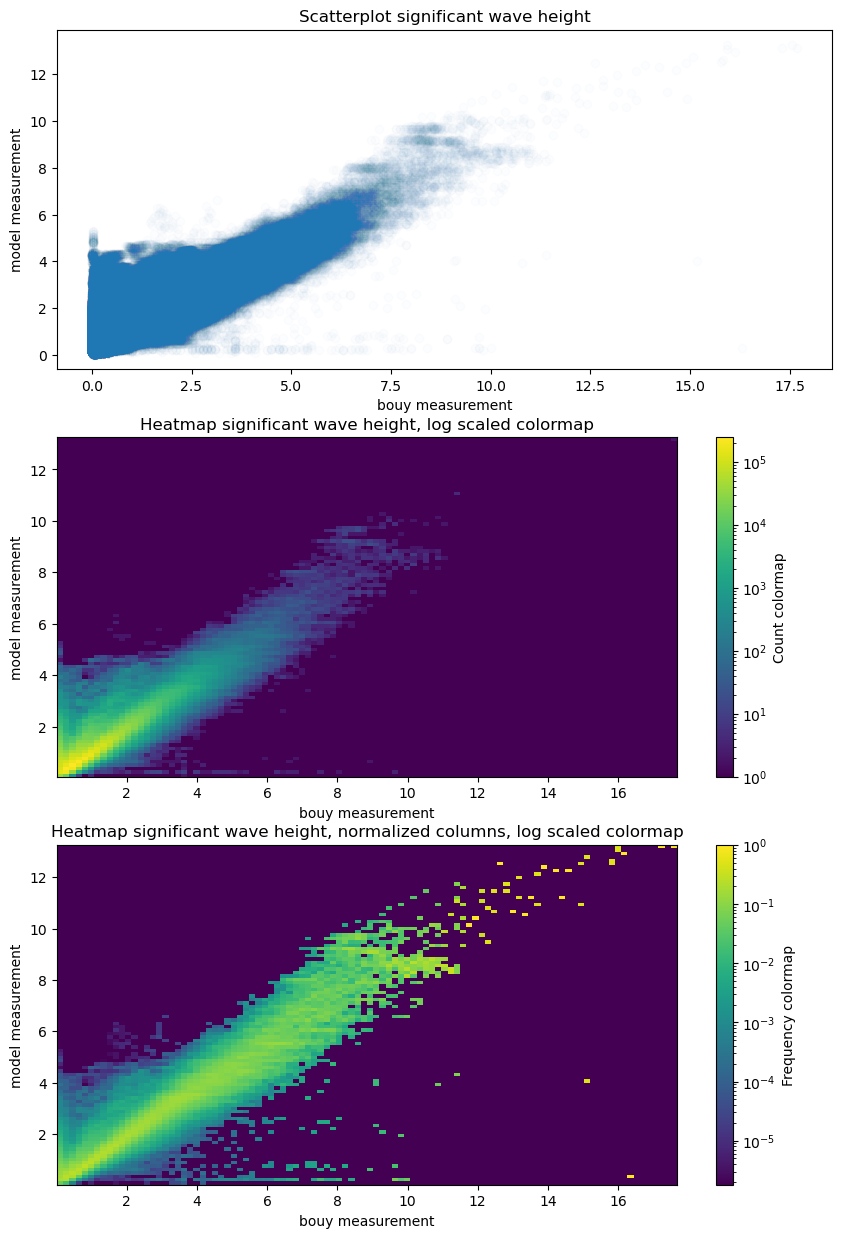

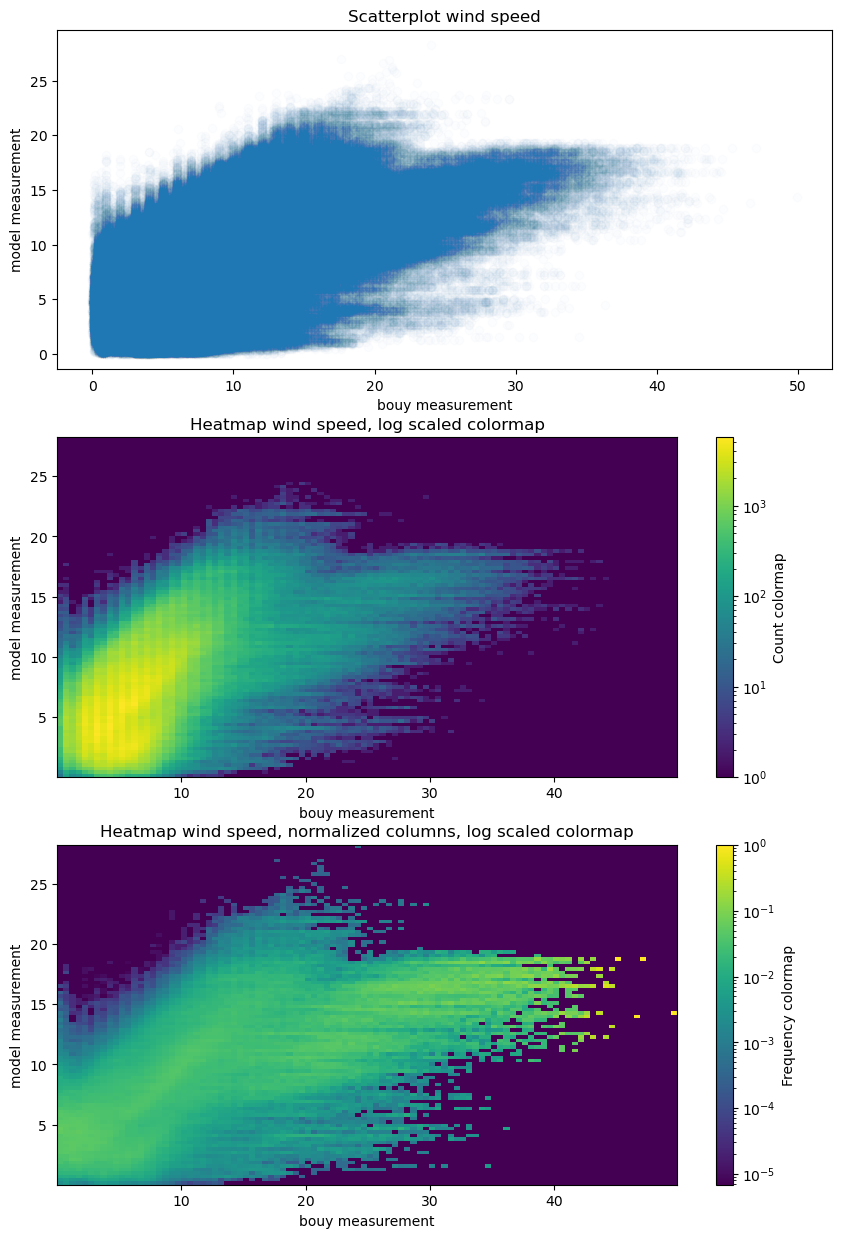

In [119]:
swh_df = result_df[(result_df['bouy_variable_name'] == 'VAVH') | (result_df['bouy_variable_name'] == 'VHM0')]
wspd_df = result_df[result_df['bouy_variable_name'] == 'WSPD']

for (name_text, df) in [('significant wave height', swh_df), ('wind speed', wspd_df)]:
    scatterplot_and_heatmaps(name_text, df)


In [120]:
print("Unique files")
np.unique(result_df['bouy_file_name'])

Unique files


array(['AR_TS_MO_Statfjord-A.nc', 'BO_TS_MO_Asko.nc',
       'BO_TS_MO_BothnianBay.nc', 'BO_TS_MO_BothnianSea.nc',
       'BO_TS_MO_BrofjordenWR.nc', 'BO_TS_MO_FinngrundetWR.nc',
       'BO_TS_MO_HelsinkiBuoy.nc', 'BO_TS_MO_HelsinkiSuomenlinna.nc',
       'BO_TS_MO_HuvudskarOst.nc', 'BO_TS_MO_Knollsgrund.nc',
       'BO_TS_MO_Koster.nc', 'BO_TS_MO_Norrbyn.nc',
       'BO_TS_MO_NorthernBaltic.nc', 'BO_TS_MO_VaderoarnaWR.nc',
       'BS_TS_MO_CG.nc', 'BS_TS_MO_EUXRo01.nc', 'BS_TS_MO_EUXRo03.nc',
       'BS_TS_MO_SPOT0772.nc', 'BS_TS_MO_SPOT0773.nc',
       'BS_TS_MO_SPOT0776.nc', 'BS_TS_MO_UGSB.nc', 'BS_TS_MO_URKA.nc',
       'BS_TS_MO_URSS.nc', 'BS_TS_MO_WAVEB01.nc', 'BS_TS_MO_WAVEB03.nc',
       'BS_TS_MO_WAVEB05.nc', 'BS_TS_MO_WD3044B.nc', 'GL_TS_MO_13010.nc',
       'GL_TS_MO_14040.nc', 'GL_TS_MO_14041.nc', 'GL_TS_MO_14043.nc',
       'GL_TS_MO_2100229.nc', 'GL_TS_MO_2200101.nc',
       'GL_TS_MO_2200102.nc', 'GL_TS_MO_2200103.nc',
       'GL_TS_MO_2200104.nc', 'GL_TS_MO_2200105.nc',

In [121]:
#Shows the value counts of bouy_file_name, bouy_variable_name pairs
result_df[result_df['bouy_variable_name'] == 'WSPD'].value_counts(subset=['bouy_file_name', 'bouy_variable_name'])

bouy_file_name                       bouy_variable_name
NO_TS_MO_PileSpiekeroog.nc           WSPD                  477142
GL_TS_MO_EXIN0006.nc                 WSPD                  171166
NO_TS_MO_ZeebruggeWeatherStation.nc  WSPD                   52400
NO_TS_MO_Blankenberge.nc             WSPD                   52297
NO_TS_MO_OostendWeather.nc           WSPD                   51969
                                                            ...  
GL_TS_MO_23009.nc                    WSPD                     150
GL_TS_MO_14041.nc                    WSPD                     134
BO_TS_MO_Asko.nc                     WSPD                     105
GL_TS_MO_23014.nc                    WSPD                      92
GL_TS_MO_13010.nc                    WSPD                      42
Length: 124, dtype: int64

In [122]:
#Returns only a scalar value from the correlation, and not the whole matrix
def two_var_df_corr(df):
    return df.corr().iloc[0,1]

In [123]:
#Print the list of tile_variable_name pairs sorted after correlation in bouy and model values
result_corr = result_df.groupby(['bouy_file_name', 'bouy_variable_name'])[['bouy_variable_value', 'model_value']].apply(two_var_df_corr).sort_values()
result_corr

bouy_file_name        bouy_variable_name
GL_TS_MO_14043.nc     WSPD                 -0.673752
BO_TS_MO_Asko.nc      WSPD                 -0.560041
GL_TS_MO_55037.nc     VAVH                 -0.298131
BS_TS_MO_SPOT0776.nc  WSPD                 -0.162226
BS_TS_MO_UGSB.nc      WSPD                 -0.069621
                                              ...   
NO_TS_MO_6300110.nc   VAVH                  0.978385
NO_TS_MO_A122.nc      VAVH                  0.978431
NO_TS_MO_A121.nc      VHM0                  0.978586
NO_TS_MO_A122.nc      VHM0                  0.979156
GL_TS_MO_46070.nc     VHM0                  0.980886
Length: 350, dtype: float64

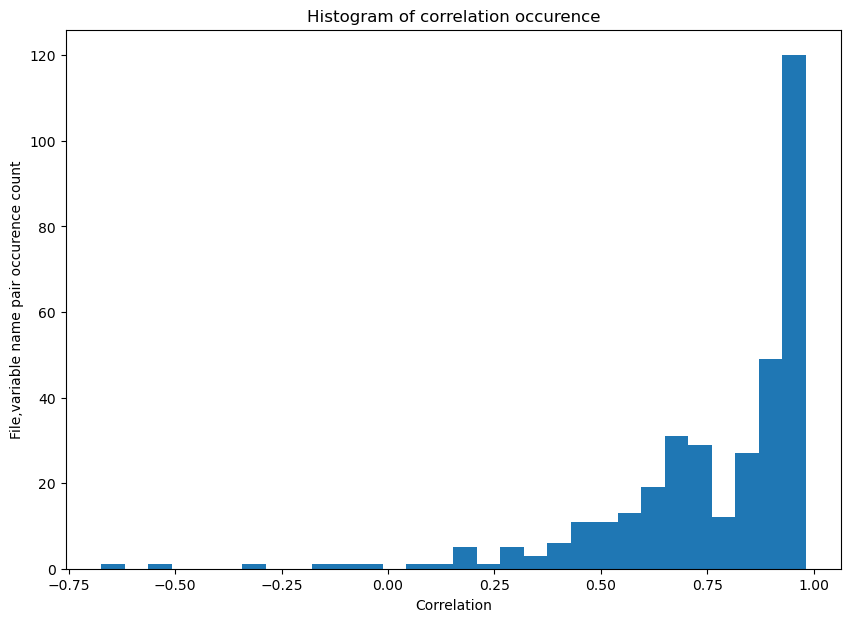

In [124]:
#Plot a histogram over the distribution of correlations
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.hist(result_corr, bins=30)
ax.set_title('Histogram of correlation occurence')
ax.set_xlabel("Correlation")
ax.set_ylabel("File,variable name pair occurence count")

display(fig)
plt.close()

('GL_TS_MO_14043.nc', 'WSPD') -0.6737519543108944
The correlation for  WSPD in GL_TS_MO_14043.nc is -0.6737519543108944
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-18 12:00:00,WSPD,5.499,3.193414,67.0,-12.0,2021-12-18 12:00:00
1,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-18 13:00:00,WSPD,4.799,3.194109,67.0,-12.0,2021-12-18 13:00:00
2,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-18 14:00:00,WSPD,4.799,3.025379,67.0,-12.0,2021-12-18 14:00:00
3,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-18 15:00:00,WSPD,4.999,2.933789,67.0,-12.0,2021-12-18 15:00:00
4,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-18 16:00:00,WSPD,5.499,2.864031,67.0,-12.0,2021-12-18 16:00:00
...,...,...,...,...,...,...,...,...,...,...
319,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-31 19:00:00,WSPD,3.699,3.690381,67.0,-12.0,2021-12-31 19:00:00
320,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-31 20:00:00,WSPD,1.999,3.522805,67.0,-12.0,2021-12-31 20:00:00
321,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-31 21:00:00,WSPD,1.999,3.420652,67.0,-12.0,2021-12-31 21:00:00
322,GL_TS_MO_14043.nc,67.0,-12.0,2021-12-31 22:00:00,WSPD,2.299,3.846679,67.0,-12.0,2021-12-31 22:00:00


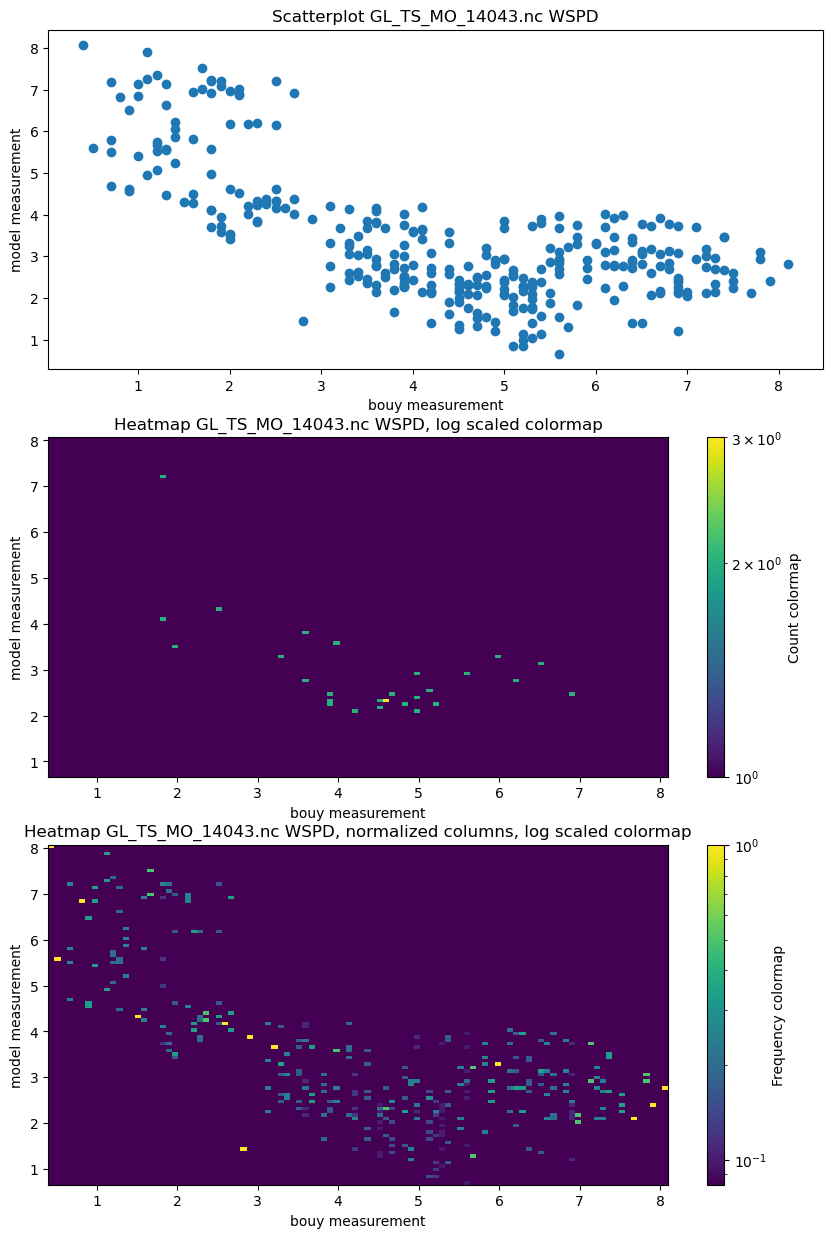

('BO_TS_MO_Asko.nc', 'WSPD') -0.5600406017097075
The correlation for  WSPD in BO_TS_MO_Asko.nc is -0.5600406017097075
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,BO_TS_MO_Asko.nc,17.625099,58.801800,2021-04-30 10:00:00,WSPD,5.0,4.757000,17.75,58.75,2021-04-30 10:00:00
1,BO_TS_MO_Asko.nc,17.625299,58.801899,2021-04-30 11:00:00,WSPD,5.0,3.998795,17.75,58.75,2021-04-30 11:00:00
2,BO_TS_MO_Asko.nc,17.625500,58.801998,2021-04-30 12:00:00,WSPD,5.6,4.168828,17.75,58.75,2021-04-30 12:00:00
3,BO_TS_MO_Asko.nc,17.625401,58.801998,2021-04-30 13:00:00,WSPD,5.2,5.066157,17.75,58.75,2021-04-30 13:00:00
4,BO_TS_MO_Asko.nc,17.625500,58.802101,2021-04-30 14:00:00,WSPD,5.0,5.427238,17.75,58.75,2021-04-30 14:00:00
...,...,...,...,...,...,...,...,...,...,...
100,BO_TS_MO_Asko.nc,17.624701,58.802200,2021-05-04 14:00:00,WSPD,5.4,2.390042,17.50,58.75,2021-05-04 14:00:00
101,BO_TS_MO_Asko.nc,17.624599,58.802200,2021-05-04 15:00:00,WSPD,4.2,2.225442,17.50,58.75,2021-05-04 15:00:00
102,BO_TS_MO_Asko.nc,17.624500,58.802101,2021-05-04 16:00:00,WSPD,6.5,2.216196,17.50,58.75,2021-05-04 16:00:00
103,BO_TS_MO_Asko.nc,17.624500,58.802101,2021-05-04 17:00:00,WSPD,8.0,2.348005,17.50,58.75,2021-05-04 17:00:00


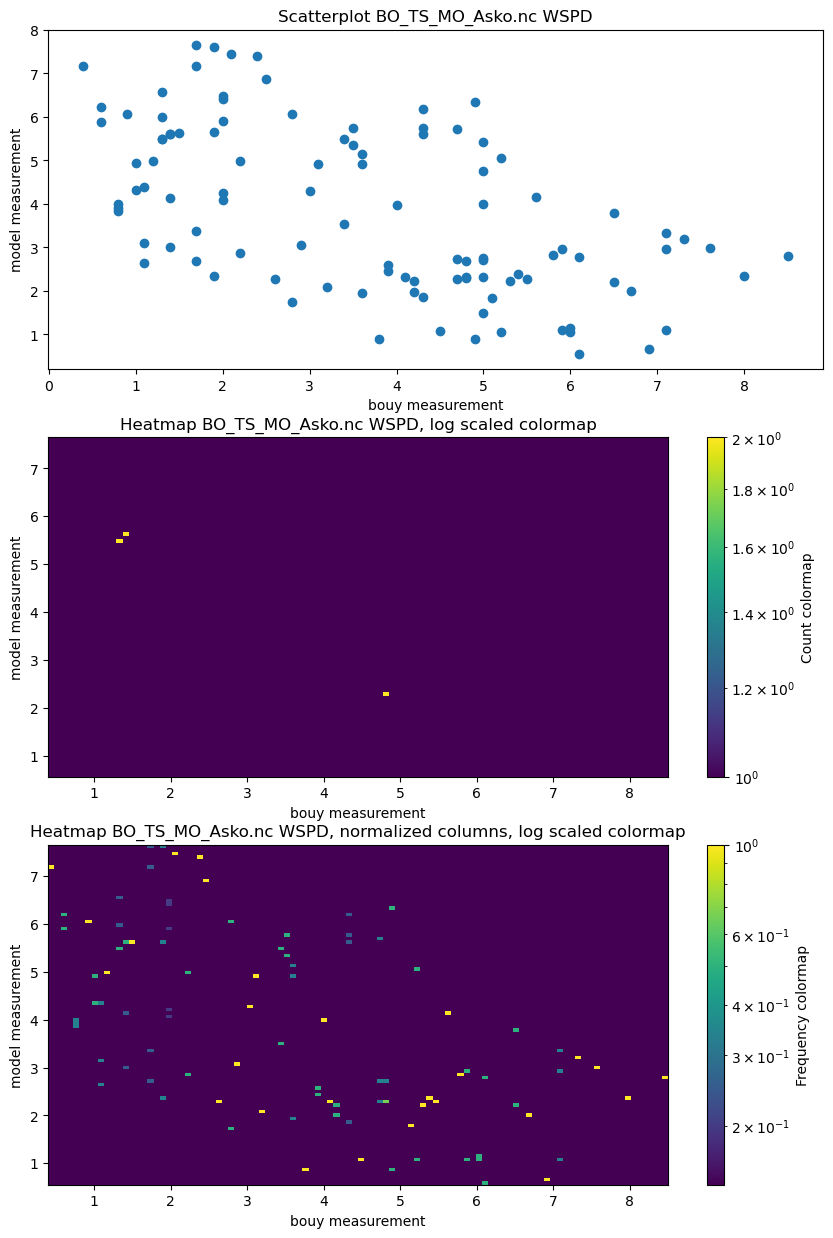

('GL_TS_MO_55037.nc', 'VAVH') -0.2981309141167539
The correlation for  VAVH in GL_TS_MO_55037.nc is -0.2981309141167539
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,GL_TS_MO_55037.nc,153.949997,-28.280001,2021-02-17 09:00:00,VAVH,0.019,2.956272,154.0,-28.5,2021-02-17 09:00:00
1,GL_TS_MO_55037.nc,153.949997,-28.280001,2021-02-17 11:00:00,VAVH,0.019,2.988337,154.0,-28.5,2021-02-17 11:00:00
2,GL_TS_MO_55037.nc,153.949997,-28.280001,2021-02-17 14:00:00,VAVH,0.019,2.751470,154.0,-28.5,2021-02-17 14:00:00
3,GL_TS_MO_55037.nc,153.949997,-28.280001,2021-02-17 23:00:00,VAVH,0.019,2.432114,154.0,-28.5,2021-02-17 23:00:00
4,GL_TS_MO_55037.nc,153.949997,-28.280001,2021-02-18 16:30:00,VAVH,0.019,2.296872,154.0,-28.5,2021-02-18 17:00:00
...,...,...,...,...,...,...,...,...,...,...
9586,GL_TS_MO_55037.nc,153.580002,-28.180000,2021-12-31 21:00:00,VAVH,2.079,1.703671,153.5,-28.0,2021-12-31 21:00:00
9587,GL_TS_MO_55037.nc,153.580002,-28.180000,2021-12-31 21:30:00,VAVH,2.019,1.704964,153.5,-28.0,2021-12-31 22:00:00
9588,GL_TS_MO_55037.nc,153.580002,-28.180000,2021-12-31 22:00:00,VAVH,2.219,1.704964,153.5,-28.0,2021-12-31 22:00:00
9589,GL_TS_MO_55037.nc,153.580002,-28.180000,2021-12-31 22:30:00,VAVH,2.119,1.694621,153.5,-28.0,2021-12-31 23:00:00


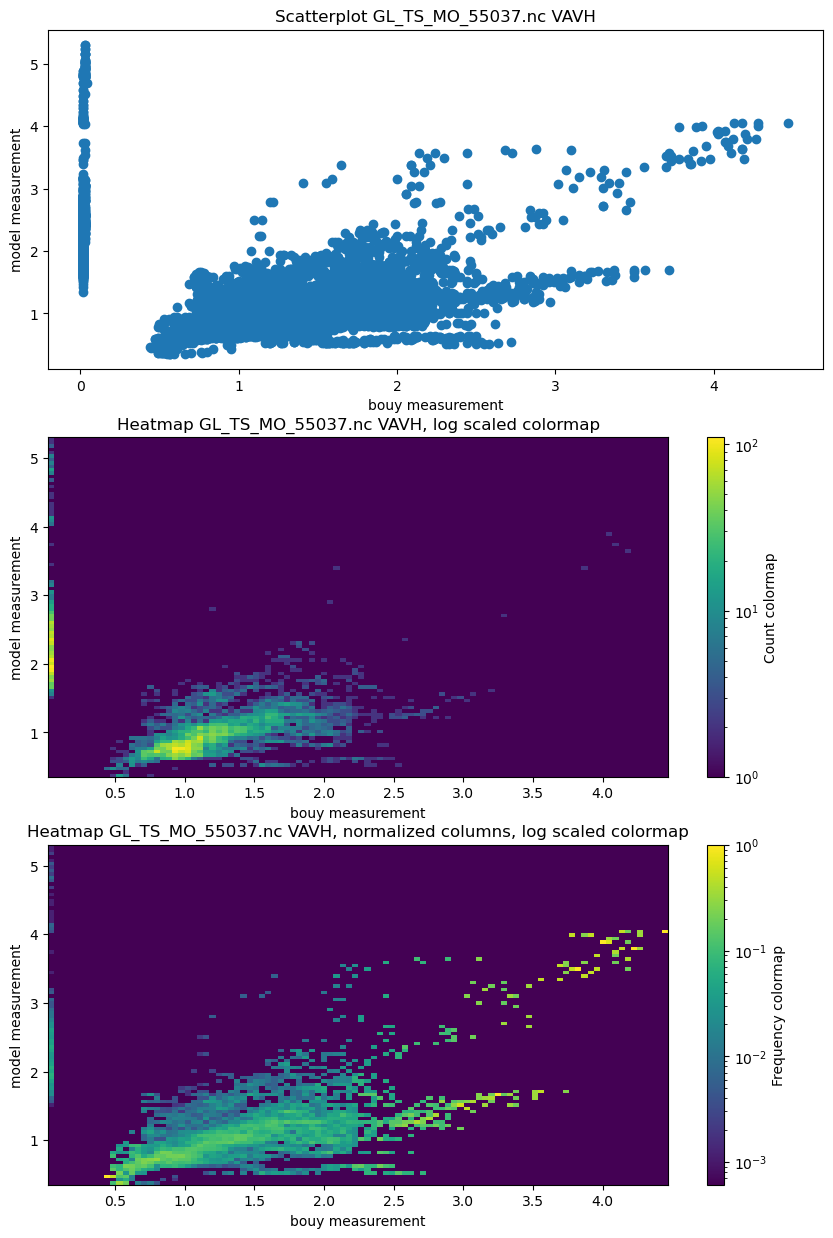

('BS_TS_MO_SPOT0776.nc', 'WSPD') -0.16222570968025188
The correlation for  WSPD in BS_TS_MO_SPOT0776.nc is -0.16222570968025188
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,BS_TS_MO_SPOT0776.nc,27.635401,42.506599,2021-01-14 07:15:00.999997952,WSPD,1.2,6.521045,27.75,42.5,2021-01-14 07:00:00
1,BS_TS_MO_SPOT0776.nc,27.635401,42.506599,2021-01-14 07:45:01.000001280,WSPD,1.2,6.295858,27.75,42.5,2021-01-14 08:00:00
2,BS_TS_MO_SPOT0776.nc,27.635401,42.506599,2021-01-14 08:15:01.000004608,WSPD,1.2,6.295858,27.75,42.5,2021-01-14 08:00:00
3,BS_TS_MO_SPOT0776.nc,27.635401,42.506599,2021-01-14 08:45:00.999997952,WSPD,1.2,6.008198,27.75,42.5,2021-01-14 09:00:00
4,BS_TS_MO_SPOT0776.nc,27.635500,42.506599,2021-01-14 09:15:01.000001280,WSPD,5.2,6.008198,27.75,42.5,2021-01-14 09:00:00
...,...,...,...,...,...,...,...,...,...,...
196,BS_TS_MO_SPOT0776.nc,27.633499,42.506699,2021-08-15 11:02:19.000003840,WSPD,3.2,3.741530,27.75,42.5,2021-08-15 11:00:00
197,BS_TS_MO_SPOT0776.nc,27.633600,42.506699,2021-08-15 11:32:18.999997184,WSPD,4.8,3.081690,27.75,42.5,2021-08-15 12:00:00
198,BS_TS_MO_SPOT0776.nc,27.633600,42.506699,2021-08-15 12:02:19.000000512,WSPD,5.6,3.081690,27.75,42.5,2021-08-15 12:00:00
199,BS_TS_MO_SPOT0776.nc,27.633600,42.506802,2021-08-15 12:32:19.000003840,WSPD,5.6,2.565786,27.75,42.5,2021-08-15 13:00:00


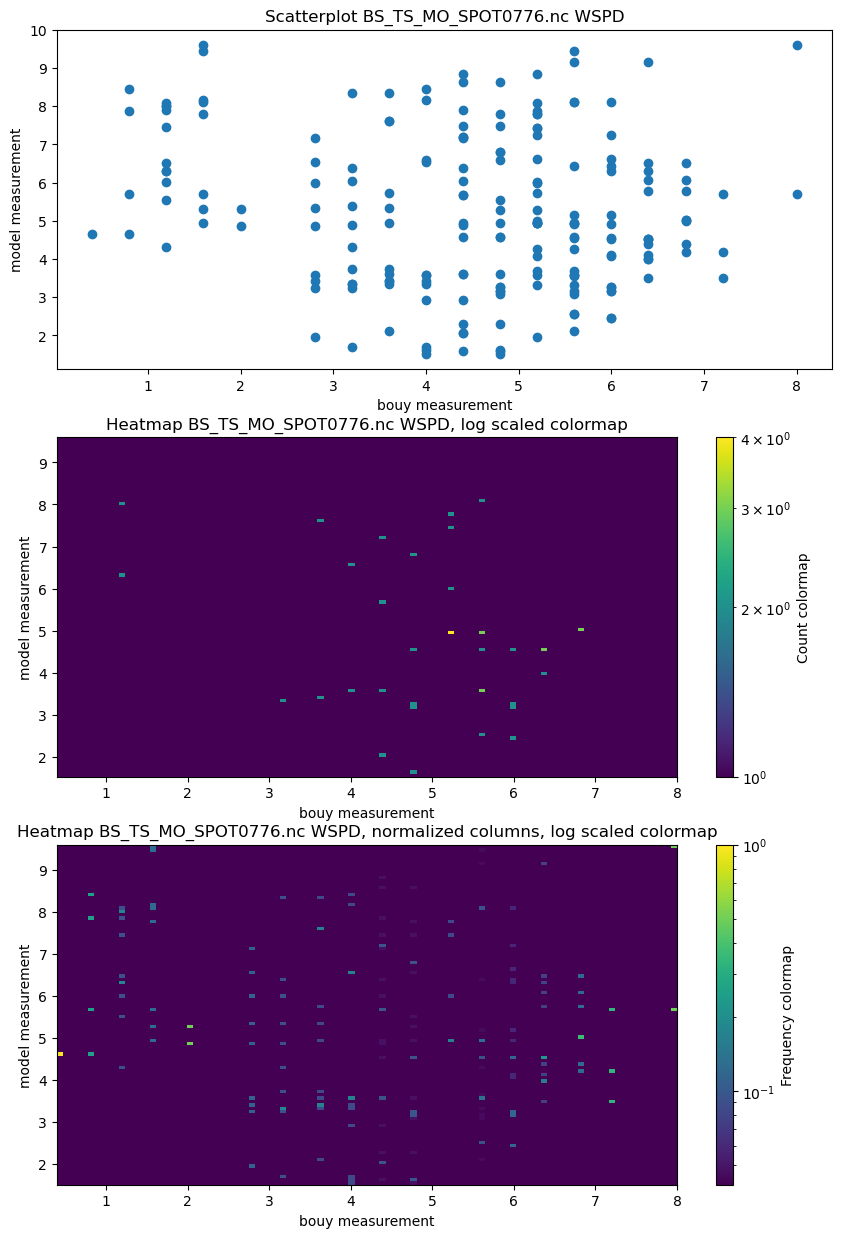

('BS_TS_MO_UGSB.nc', 'WSPD') -0.06962138879593303
The correlation for  WSPD in BS_TS_MO_UGSB.nc is -0.06962138879593303
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-01-01 00:00:00.000000000,WSPD,7.717,5.203005,41.5,41.75,2021-01-01 00:00:00
1,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-01-01 00:30:00.000003328,WSPD,9.774,5.292997,41.5,41.75,2021-01-01 01:00:00
2,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-01-01 00:59:59.999996672,WSPD,10.289,5.292997,41.5,41.75,2021-01-01 01:00:00
3,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-01-01 01:30:00.000000000,WSPD,9.774,5.193565,41.5,41.75,2021-01-01 02:00:00
4,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-01-01 02:00:00.000003328,WSPD,8.746,5.193565,41.5,41.75,2021-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...
17176,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-12-31 20:29:59.999996672,WSPD,6.688,8.495467,41.5,41.75,2021-12-31 20:00:00
17177,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-12-31 21:00:00.000000000,WSPD,6.173,8.060768,41.5,41.75,2021-12-31 21:00:00
17178,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-12-31 21:30:00.000003328,WSPD,6.173,7.884569,41.5,41.75,2021-12-31 22:00:00
17179,BS_TS_MO_UGSB.nc,41.599998,41.633301,2021-12-31 21:59:59.999996672,WSPD,6.173,7.884569,41.5,41.75,2021-12-31 22:00:00


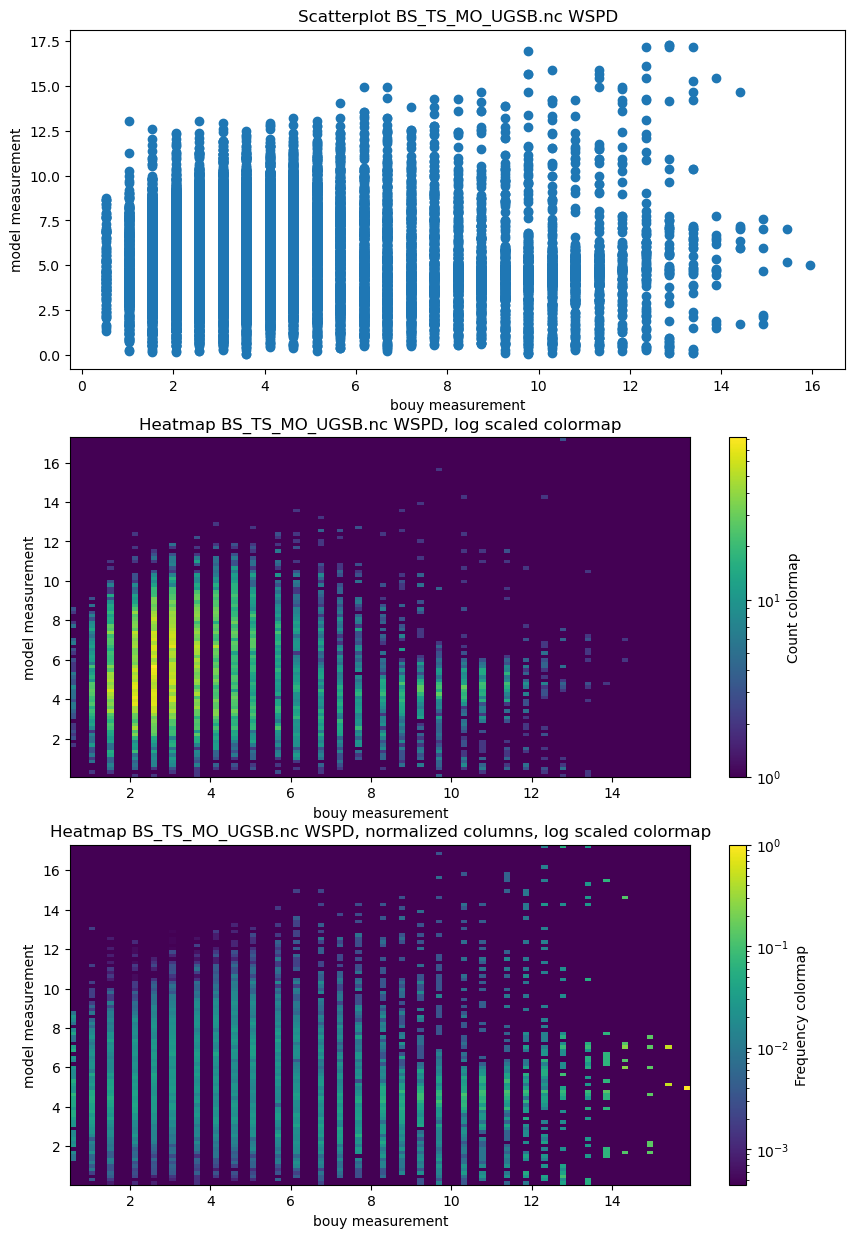

('BS_TS_MO_URSS.nc', 'WSPD') -0.02921414507181052
The correlation for  WSPD in BS_TS_MO_URSS.nc is -0.02921414507181052
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-01-01 00:00:00.000000000,WSPD,5.998,2.040236,40.0,43.5,2021-01-01 00:00:00
1,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-01-01 00:30:00.000003328,WSPD,5.998,1.761855,40.0,43.5,2021-01-01 01:00:00
2,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-01-01 00:59:59.999996672,WSPD,5.000,1.761855,40.0,43.5,2021-01-01 01:00:00
3,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-01-01 01:30:00.000000000,WSPD,5.998,1.647116,40.0,43.5,2021-01-01 02:00:00
4,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-01-01 02:00:00.000003328,WSPD,5.000,1.647116,40.0,43.5,2021-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...
16901,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-12-31 20:29:59.999996672,WSPD,5.998,5.264095,40.0,43.5,2021-12-31 20:00:00
16902,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-12-31 21:00:00.000000000,WSPD,5.998,5.168808,40.0,43.5,2021-12-31 21:00:00
16903,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-12-31 21:30:00.000003328,WSPD,7.002,4.663234,40.0,43.5,2021-12-31 22:00:00
16904,BS_TS_MO_URSS.nc,39.900002,43.4333,2021-12-31 21:59:59.999996672,WSPD,5.998,4.663234,40.0,43.5,2021-12-31 22:00:00


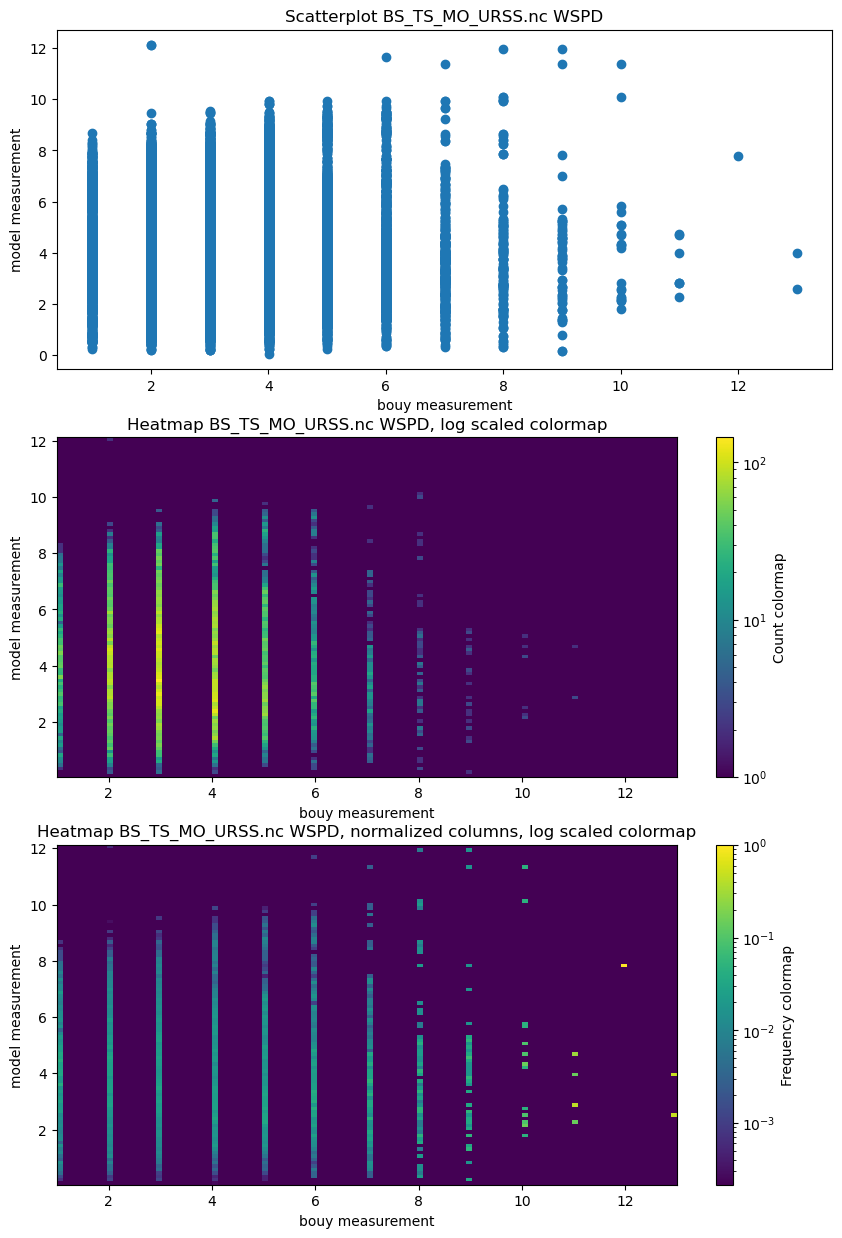

('NO_TS_MO_A122.nc', 'VHM0') 0.9791558574370103
The correlation for  VHM0 in NO_TS_MO_A122.nc is 0.9791558574370103
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,NO_TS_MO_A122.nc,3.817,55.417999,2021-01-01 00:00:00.000000000,VHM0,1.04,1.060822,4.0,55.5,2021-01-01 00:00:00
1,NO_TS_MO_A122.nc,3.817,55.417999,2021-01-01 00:10:00.000000000,VHM0,1.06,1.060822,4.0,55.5,2021-01-01 00:00:00
2,NO_TS_MO_A122.nc,3.817,55.417999,2021-01-01 00:20:00.000000256,VHM0,0.99,1.060822,4.0,55.5,2021-01-01 00:00:00
3,NO_TS_MO_A122.nc,3.817,55.417999,2021-01-01 00:30:00.000000000,VHM0,1.01,1.055391,4.0,55.5,2021-01-01 01:00:00
4,NO_TS_MO_A122.nc,3.817,55.417999,2021-01-01 00:40:00.000000000,VHM0,1.04,1.055391,4.0,55.5,2021-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...
43709,NO_TS_MO_A122.nc,3.817,55.417999,2021-12-31 22:20:00.000000000,VHM0,1.72,2.049145,4.0,55.5,2021-12-31 22:00:00
43710,NO_TS_MO_A122.nc,3.817,55.417999,2021-12-31 22:30:00.000000000,VHM0,1.68,2.035440,4.0,55.5,2021-12-31 23:00:00
43711,NO_TS_MO_A122.nc,3.817,55.417999,2021-12-31 22:40:00.000000000,VHM0,1.75,2.035440,4.0,55.5,2021-12-31 23:00:00
43712,NO_TS_MO_A122.nc,3.817,55.417999,2021-12-31 22:50:00.000000256,VHM0,1.78,2.035440,4.0,55.5,2021-12-31 23:00:00


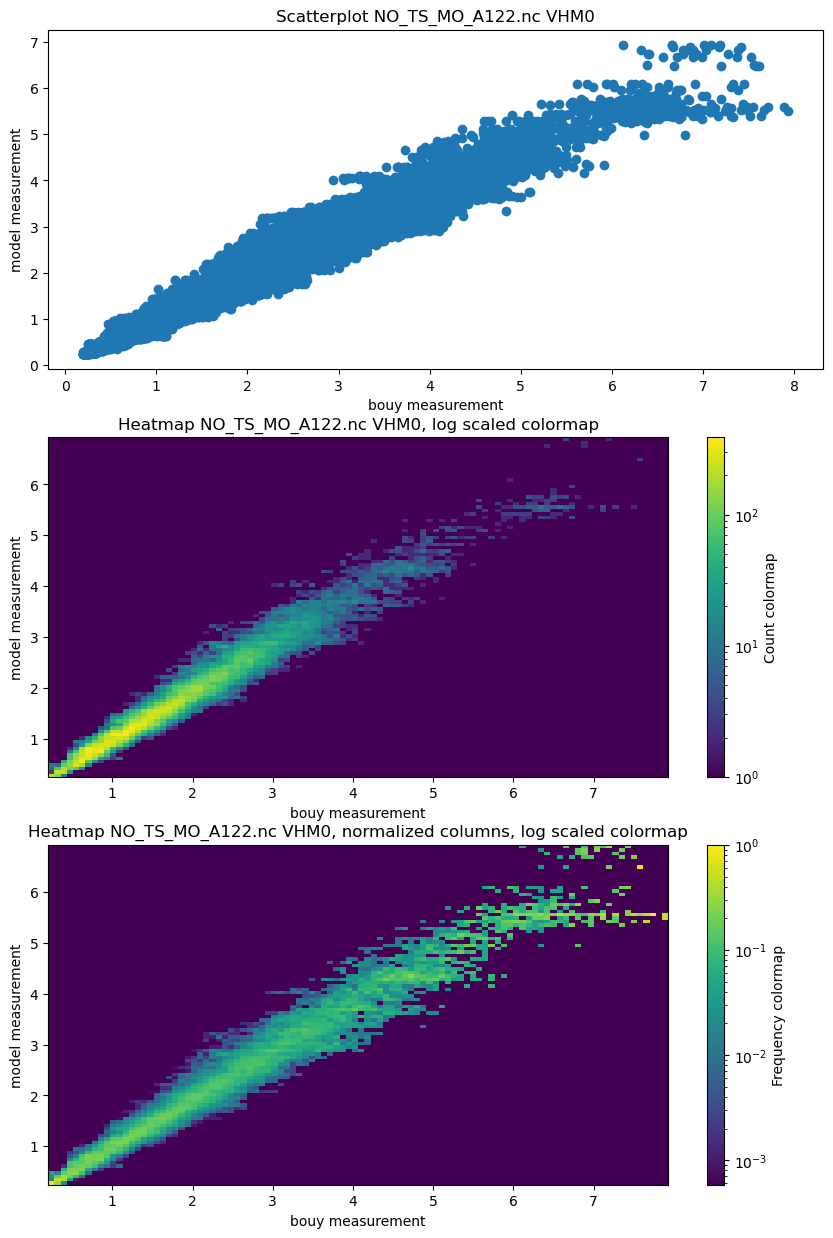

('GL_TS_MO_46070.nc', 'VHM0') 0.9808859098359011
The correlation for  VHM0 in GL_TS_MO_46070.nc is 0.9808859098359011
The dataframe


,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,GL_TS_MO_46070.nc,175.182999,55.007999,2021-07-04 12:50:00.000000000,VHM0,1.279,1.152879,175.0,55.0,2021-07-04 13:00:00
1,GL_TS_MO_46070.nc,175.182999,55.007999,2021-07-04 13:50:00.000000256,VHM0,1.479,1.135812,175.0,55.0,2021-07-04 14:00:00
2,GL_TS_MO_46070.nc,175.182999,55.007999,2021-07-04 14:50:00.000000000,VHM0,1.359,1.120039,175.0,55.0,2021-07-04 15:00:00
3,GL_TS_MO_46070.nc,175.182999,55.007999,2021-07-04 15:50:00.000000000,VHM0,1.219,1.105557,175.0,55.0,2021-07-04 16:00:00
4,GL_TS_MO_46070.nc,175.182999,55.007999,2021-07-04 16:50:00.000000256,VHM0,1.169,1.092370,175.0,55.0,2021-07-04 17:00:00
...,...,...,...,...,...,...,...,...,...,...
3598,GL_TS_MO_46070.nc,175.182999,55.007999,2021-12-31 18:50:00.000000000,VHM0,5.999,4.159223,175.0,55.0,2021-12-31 19:00:00
3599,GL_TS_MO_46070.nc,175.182999,55.007999,2021-12-31 19:50:00.000000256,VHM0,4.979,4.188961,175.0,55.0,2021-12-31 20:00:00
3600,GL_TS_MO_46070.nc,175.182999,55.007999,2021-12-31 20:50:00.000000000,VHM0,5.199,4.234213,175.0,55.0,2021-12-31 21:00:00
3601,GL_TS_MO_46070.nc,175.182999,55.007999,2021-12-31 21:50:00.000000000,VHM0,4.529,4.305067,175.0,55.0,2021-12-31 22:00:00


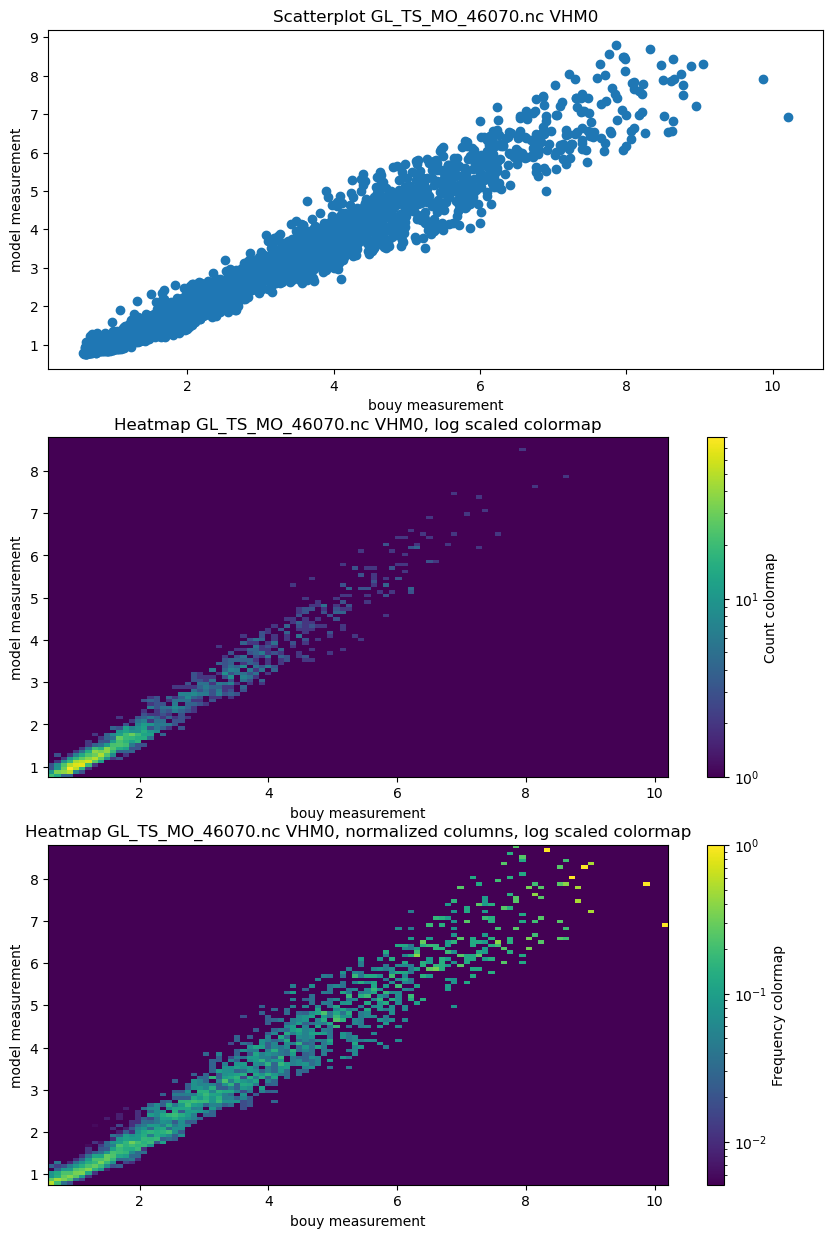

In [125]:
for (file_name, variable_name),corr in pd.concat([result_corr.iloc[:6], result_corr.iloc[-2:]]).items():
    print((file_name, variable_name), corr)
    df_filtered = result_df[(result_df['bouy_file_name'] == file_name) & (result_df['bouy_variable_name'] == variable_name)]
    print("The correlation for ", variable_name, 'in', file_name, 'is', corr)
    print("The dataframe")
    display(df_filtered)
    scatterplot_and_heatmaps(file_name + ' ' + variable_name, df_filtered, alpha=1)
    


In [126]:
result_df

,bouy_file_name,bouy_longitude,bouy_latitude,bouy_time,bouy_variable_name,bouy_variable_value,model_value,model_longitude,model_latitude,model_time
0,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 00:00:00,WSPD,7.299,3.107290,80.5,-12.0,2021-01-01 00:00:00
1,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 01:00:00,WSPD,3.099,3.274450,80.5,-12.0,2021-01-01 01:00:00
2,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 02:00:00,WSPD,3.699,4.073387,80.5,-12.0,2021-01-01 02:00:00
3,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 03:00:00,WSPD,3.899,4.935715,80.5,-12.0,2021-01-01 03:00:00
4,GL_TS_MO_53006.nc,80.500000,-12.000000,2021-01-01 04:00:00,WSPD,5.499,4.728475,80.5,-12.0,2021-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
866,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-29 15:00:00,VAVH,1.649,1.581359,115.5,-32.0,2021-12-29 15:00:00
867,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-30 18:00:00,VAVH,2.139,1.752544,115.5,-32.0,2021-12-30 18:00:00
868,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-31 06:00:00,VAVH,1.899,1.729530,115.5,-32.0,2021-12-31 06:00:00
869,GL_TS_MO_56005.nc,115.419998,-32.099998,2021-12-31 09:00:00,VAVH,2.009,2.069573,115.5,-32.0,2021-12-31 09:00:00


In [127]:
#Save the worst files in regards to correlation as a kml map

write_folder = read_folder

low_corr = result_corr[result_corr < 0.50]
high_corr = result_corr[result_corr > 0.75]

for (filtered_corr, KML_name, KML_file, ) in [(low_corr, 'Correlation < 0.5', 'low_corr.kml'),
                                              (high_corr, 'Correlation > 0.75', 'high_corr.kml')]:

    #Create kml map
    KML_fldr = KML.Folder(
        KML.name(KML_name),
        KML.description("From " + write_folder)
    )

    #For these entries save as kml
    for (file_name, var_name),corr in filtered_corr.items():
        df = result_df[(result_df['bouy_file_name'] == file_name) & (result_df['bouy_variable_name'] == var_name)]
        long = df['bouy_longitude'].mean()
        lat = df['bouy_latitude'].mean()
        count = df.shape[0]
        
        #Create the pin
        pin = KML.Placemark(
            KML.name(file_name + ' ' + var_name + ' corr:' + str(corr)),
            KML.description(str(count) + " datapoints"),
            KML.Point(
                KML.coordinates(str(long) + "," + str(lat))
            )
        )
        KML_fldr.append(pin)
            
    with open(os.path.join(write_folder, KML_file), 'w') as f_w:
        f_w.write(lxml.etree.tostring(KML_fldr, pretty_print=True).decode())